# Information Theory Considerations in Patch-based Training of Deep Neural Networks on Seismic Time-Series

This notebook explores and reproduces frequency aliasing due to windowing of patches of seismic data in patch-based neural network training.

> [Dramsch, J. S.](https://orcid.org/0000-0001-8273-905X), & [Lüthje, M.](https://orcid.org/0000-0003-2715-1653). (2018, November). Information Theory Considerations in Patch-based Training of Deep Neural Networks on Seismic Time-Series. In First EAGE/PESGB Workshop Machine Learning.

[[Code on Github]](https://github.com/JesperDramsch/windowing-seismic-for-deep-learning)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
plt.ion()
import segyio
import random

## Data
We're using the Dutch F3 data set to make data reproducible. Loading it and arbitrarily using trace 30000. The trace is split into two parts for some preliminary analysis. We have to consider that the right part probably contains more lower frequencies and less higher frequencies, due to being deeper.

In [2]:
filename = 'f3.segy'

In [3]:
with segyio.open(filename) as f:
    
    f.mmap()
    
    x = segyio.tools.collect(f.trace[:])

In [4]:
x.shape

(619101, 462)

462


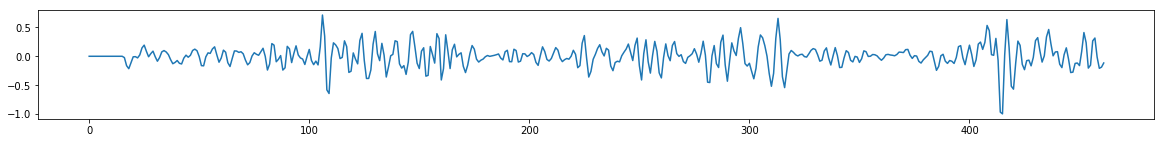

In [5]:
trace = x[30000,:]
trace /= np.max(np.abs(trace))
plt.figure(figsize=(20,2))
plt.plot(trace)
print(len(trace))

In [6]:
sp = np.abs(np.fft.fft(trace))
sp /= np.max(sp)

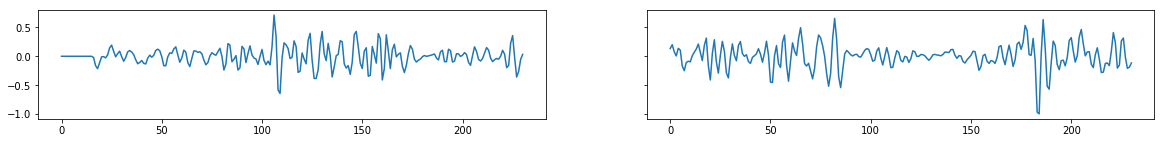

231


In [7]:
half_trace_left = trace[:len(trace)//2]
half_trace_right = trace[len(trace)//2:]
plt.figure(figsize=(20,2))
ax1 = plt.subplot(1,2,1)
plt.plot(half_trace_left)
ax2 = plt.subplot(1,2,2, sharey=ax1)
plt.plot(half_trace_right)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.show()
print(len(half_trace_left))

## Downsampling and Classic Aliasing
Let's have a quick look of the effect of down-sampling the data by slicing, a common practice in Python, Matlab and R.

Many parts of the exploration in this abstract rely on the [Nyquist-Shannon theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem), considering that we'll talk about aliasing. Usually, we have to assume $\frac{1}{\Delta t} = 2\cdot f_{max}$. So downsampling by the factor of two then results in:

$$ \frac{1}{\Delta t_{lower}} = 2\cdot \frac{f_{max}}{2} $$

Therefore, we expect classic aliasing to occure (which it does below) when not filtering the data to exclude higher frequencies.

In [8]:
sp_left_half = np.abs(np.fft.fft(half_trace_left))
sp_left_half /= np.max(sp_left_half)
sp_right_half = np.abs(np.fft.fft(half_trace_right))
sp_right_half /= np.max(sp_right_half)

In [9]:
time_step = .004
freqs = np.fft.fftfreq(sp.size, d=time_step)
idx = np.argsort(freqs)
freqs_left_half = np.fft.fftfreq(sp_left_half.size, d=time_step)
idx_left_half = np.argsort(freqs_left_half)
freqs_right_half = np.fft.fftfreq(sp_right_half.size, d=time_step)
idx_right_half = np.argsort(freqs_right_half)

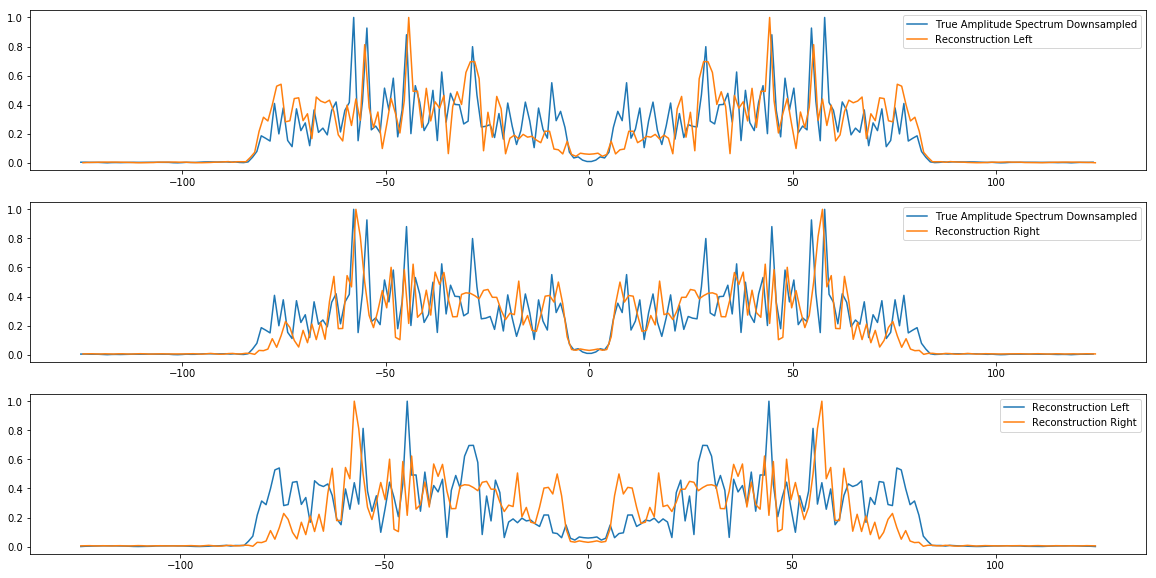

In [10]:
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(freqs[idx][::2], sp[idx][::2], label="True Amplitude Spectrum Downsampled")
plt.plot(freqs_left_half[idx_left_half], (sp_left_half[idx_left_half]), label="Reconstruction Left")
plt.legend()
plt.subplot(312)
plt.plot(freqs[idx][::2], sp[idx][::2], label="True Amplitude Spectrum Downsampled")
plt.plot(freqs_right_half[idx_right_half], (sp_right_half[idx_right_half]), label="Reconstruction Right")
plt.legend()
plt.subplot(313)
plt.plot(freqs_left_half[idx_left_half], (sp_left_half[idx_left_half]), label="Reconstruction Left")
plt.plot(freqs_right_half[idx_right_half], (sp_right_half[idx_right_half]), label="Reconstruction Right")
#plt.plot(freqs[idx], sp[idx], label="True Amplitude Spectrum", alpha=.3)
plt.legend()

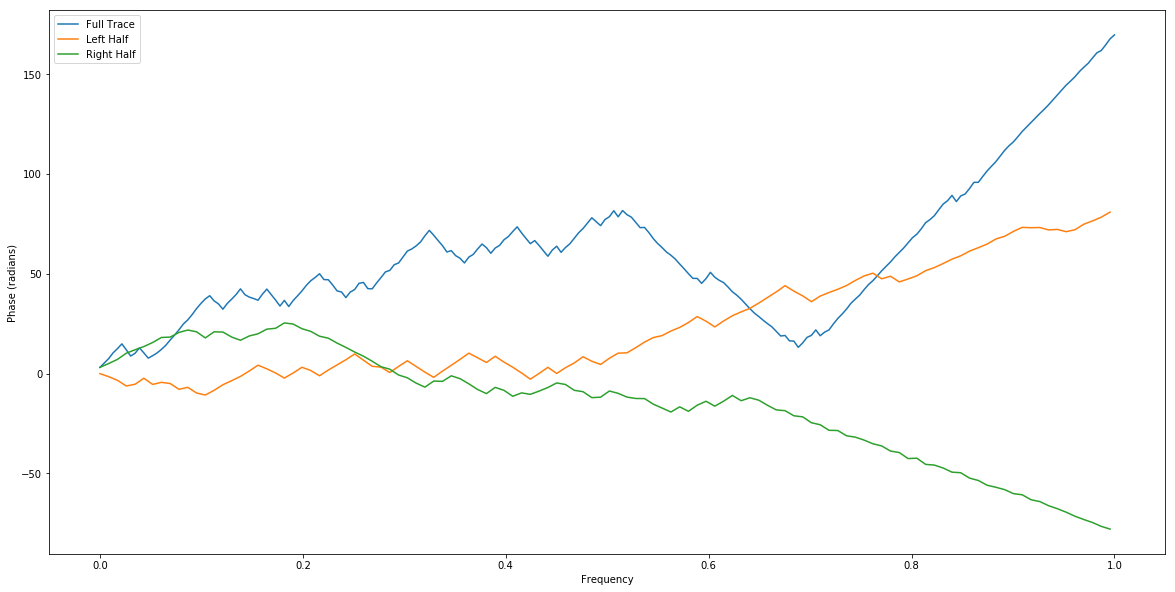

In [11]:
plt.figure(figsize=(20,10))
plt.phase_spectrum(trace, label="Full Trace")
plt.phase_spectrum(half_trace_left, label="Left Half")
plt.phase_spectrum(half_trace_right, label="Right Half")
plt.legend()
plt.show()

Additionally, we have to taper the data, to adjust for edge effects when cutting up our signal and Fourier transforming those snippets.

In [12]:
def tapedat(insi):
    taper = np.hanning(40)
    return np.concatenate((taper[:20],np.repeat(1,len(insi)-40),taper[20:]))

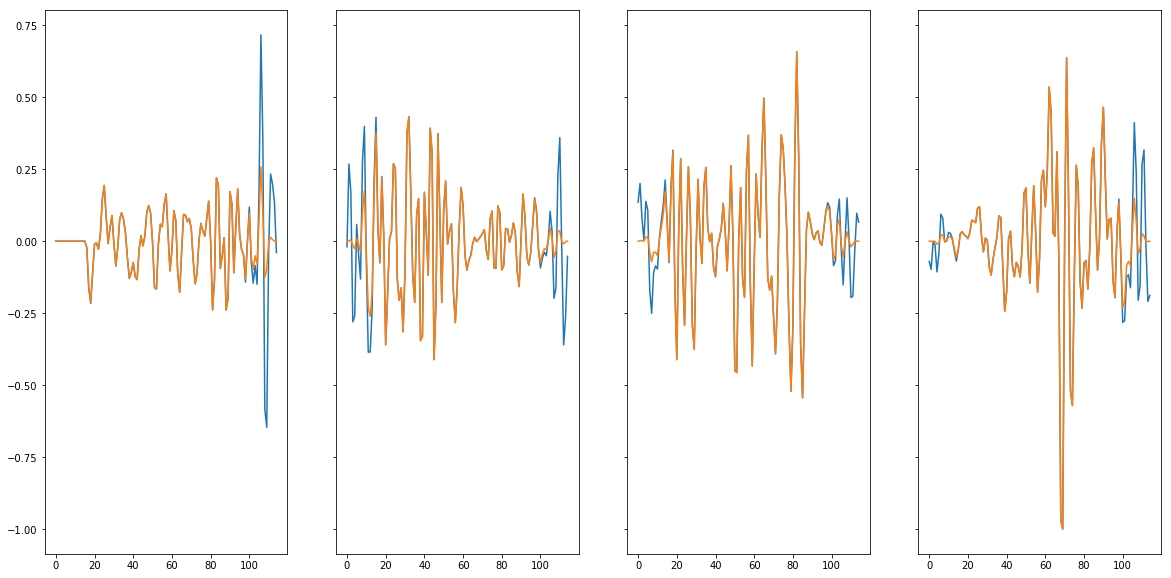

In [13]:
half_trace_left = trace[:len(trace)//4]
half_trace_midl = trace[len(trace)//4:len(trace)//2-1]
half_trace_midr = trace[len(trace)//2:3*len(trace)//4]
half_trace_right = trace[3*len(trace)//4:-1]

taper = np.hanning(20)

hann_half_trace_left = np.multiply(half_trace_left,tapedat(half_trace_left))
hann_half_trace_midl = np.multiply(half_trace_midl,tapedat(half_trace_midl))
hann_half_trace_midr = np.multiply(half_trace_midr,tapedat(half_trace_midr))
hann_half_trace_right = np.multiply(half_trace_right,tapedat(half_trace_right))



plt.figure(figsize=(20,10))
ax1 = plt.subplot(1,4,1)
plt.plot(half_trace_left)
plt.plot(hann_half_trace_left)
ax2 = plt.subplot(1,4,2, sharey=ax1)
plt.plot(half_trace_midl)
plt.plot(hann_half_trace_midl)
plt.setp(ax2.get_yticklabels(), visible=False)

ax3 = plt.subplot(1,4,3, sharey=ax1)
plt.plot(half_trace_midr)
plt.plot(hann_half_trace_midr)
plt.setp(ax3.get_yticklabels(), visible=False)

ax4 = plt.subplot(1,4,4, sharey=ax1)
plt.plot(half_trace_right)
plt.plot(hann_half_trace_right)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.show()

In [14]:
def freq_out(trace_in):
    time_step = .004
    sp = np.abs(np.fft.fft(trace_in))
    sp_norm = sp / np.max(sp)
    freqs = np.fft.fftfreq(sp.size, d=time_step)
    idx = np.argsort(freqs)
    return (sp, sp_norm, freqs, idx)

In [15]:
(sp_left_true, sp_left, freqs_left, idx_left) = freq_out(half_trace_left)
(sp_midl_true, sp_midl, freqs_midl, idx_midl) = freq_out(half_trace_midl)
(sp_midr_true, sp_midr, freqs_midr, idx_midr) = freq_out(half_trace_midr)
(sp_right_true, sp_right, freqs_right, idx_right) = freq_out(half_trace_right)

In [16]:
(hann_sp_left_true, hann_sp_left, hann_freqs_left, hann_idx_left) = freq_out(hann_half_trace_left)
(hann_sp_midl_true, hann_sp_midl, hann_freqs_midl, hann_idx_midl) = freq_out(hann_half_trace_midl)
(hann_sp_midr_true, hann_sp_midr, hann_freqs_midr, hann_idx_midr) = freq_out(hann_half_trace_midr)
(hann_sp_right_true, hann_sp_right, hann_freqs_right, hann_idx_right) = freq_out(hann_half_trace_right)

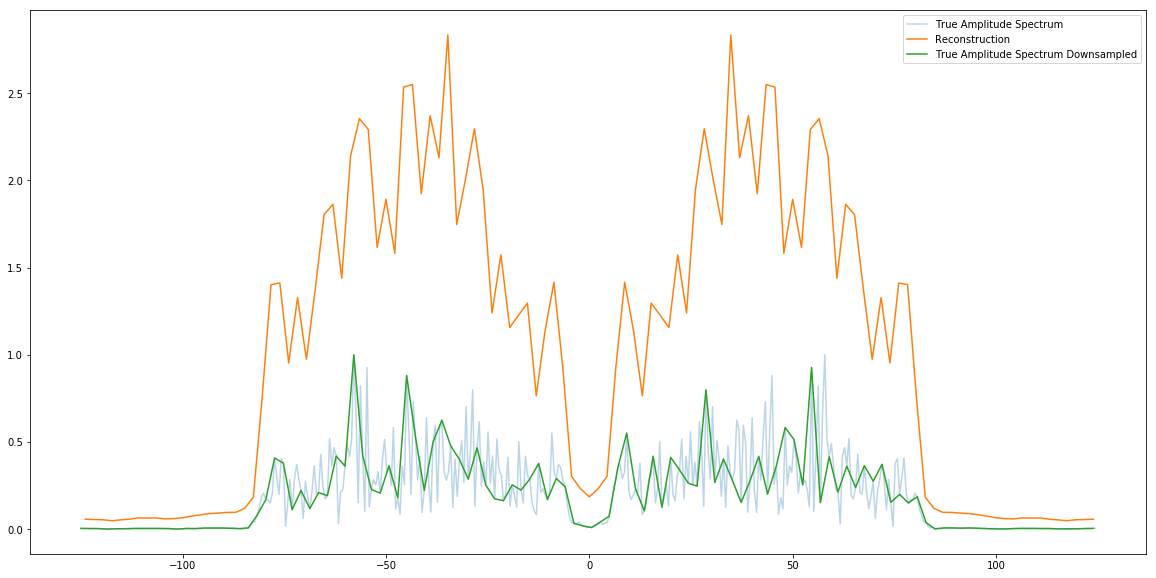

In [17]:
plt.figure(figsize=(20,10))
plt.plot(freqs[idx], sp[idx], label="True Amplitude Spectrum", alpha=.3)
plt.plot(freqs_left[idx_left], (sp_left[idx_left]+sp_midl[idx_midl]+sp_midr[idx_midr]+sp_right[idx_right]), label="Reconstruction")
plt.plot(freqs[idx][::4], sp[idx][::4], label="True Amplitude Spectrum Downsampled")
plt.legend()


Clearly we have to normalize the spectra.

In [18]:
start = 3*len(trace)//4
half_trace_short = trace[start:start+101]
half_trace_mid = trace[start:start+256]
half_trace_left = trace[len(trace)//4:len(trace)//2-1]
half_trace_right = trace[len(trace)//2:3*len(trace)//4]

In [19]:
hann_half_trace_left = np.multiply(half_trace_left,tapedat(half_trace_left))
hann_half_trace_right = np.multiply(half_trace_right,tapedat(half_trace_right))
hann_half_trace_short = np.multiply(half_trace_short,tapedat(half_trace_short))
hann_half_trace_mid = np.multiply(half_trace_mid,tapedat(half_trace_mid))

In [20]:
(sp_left_true, sp_left, freqs_left, idx_left) = freq_out(half_trace_left)
(sp_right_true, sp_right, freqs_right, idx_right) = freq_out(half_trace_right)

In [21]:
(hann_sp_left_true, hann_sp_left, hann_freqs_left, hann_idx_left) = freq_out(hann_half_trace_left)
(hann_sp_right_true, hann_sp_right, hann_freqs_right, hann_idx_right) = freq_out(hann_half_trace_right)

In [22]:
(hann_sp_short_true, hann_sp_short, hann_freqs_short, hann_idx_short) = freq_out(hann_half_trace_short)
(hann_sp_mid_true, hann_sp_mid, hann_freqs_mid, hann_idx_mid) = freq_out(hann_half_trace_mid)

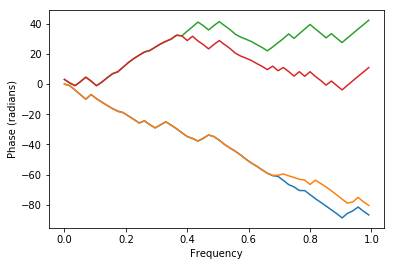

In [23]:
spec, freq, _ = plt.phase_spectrum(half_trace_left, label="Phase")
hann_spec, hann_freq, _ = plt.phase_spectrum(hann_half_trace_left, label="Phase Hanning")

spec_total = spec
hann_spec_total = hann_spec
frex_total = freq
hann_frex_total = hann_freq

spec, freq, _ = plt.phase_spectrum(half_trace_right)
hann_spec, hann_freq, _ = plt.phase_spectrum(hann_half_trace_right)

spec_total += spec
hann_spec_total += hann_spec



## Frequency Effects of Windowing

Despite all efforts to avoid edge effects or aliasing, it is apparent, that low frequencies are strongly altered dependent on window size.

In [24]:
def cutout(seq,val):
        """
        Remove element at `idx` from `seq`.
        TODO: error checks.
        """
        mid = len(seq)//2
        return seq[mid-val//2:mid+val//2]

C:\Users\jdram\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


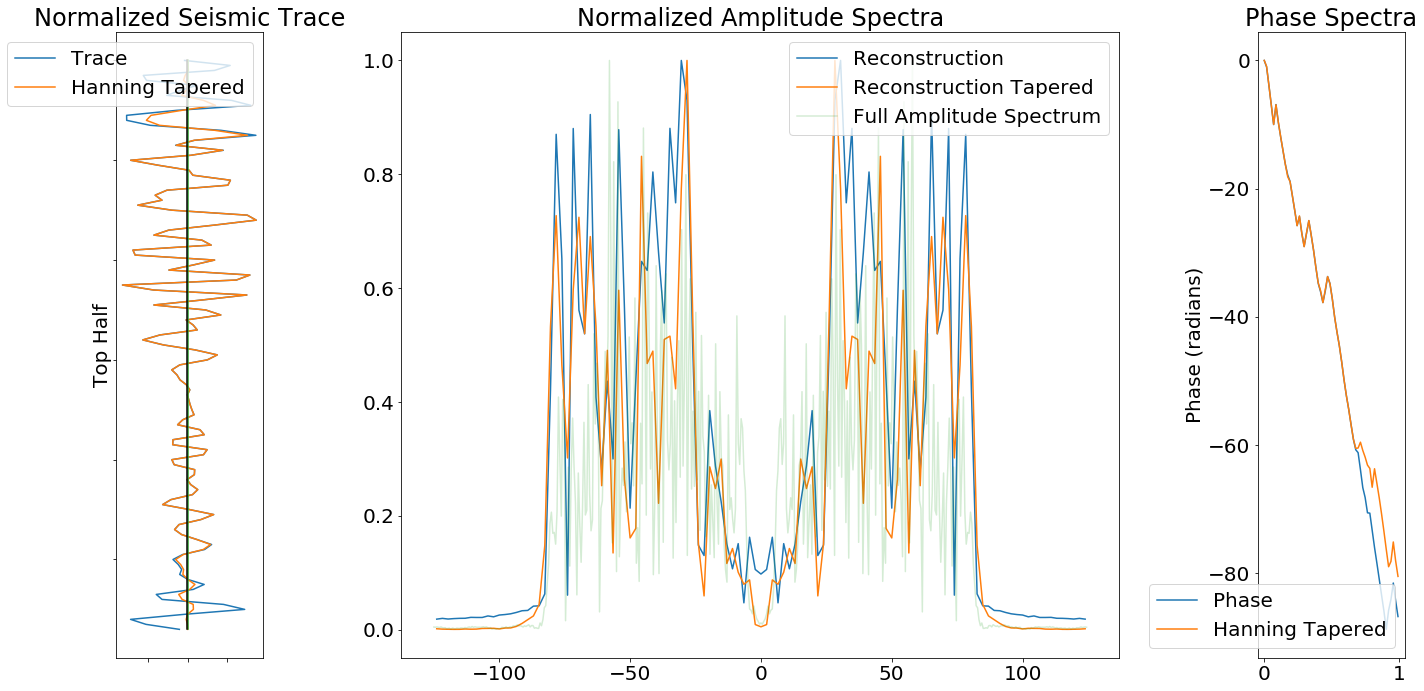

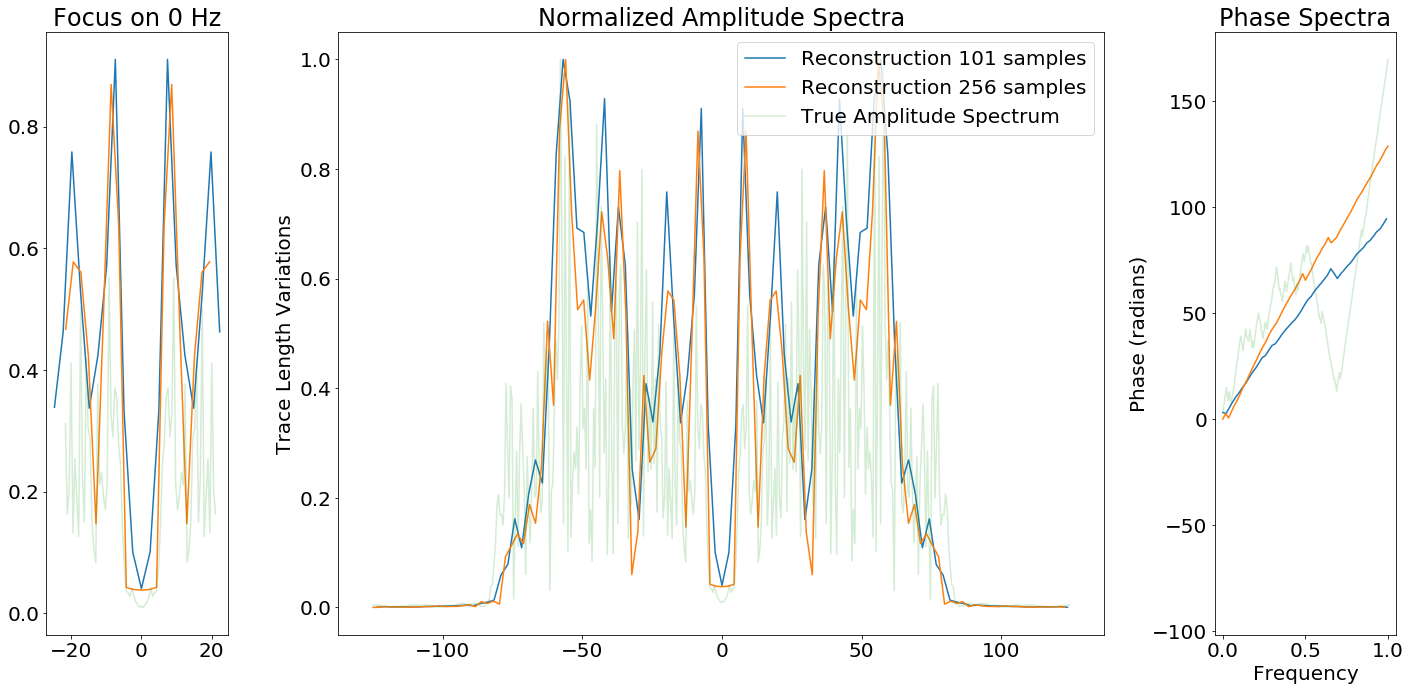

In [25]:
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(20, 10), tight_layout=True)

ax12 = plt.subplot2grid((1, 5), (0, 1), colspan=3)
ax12.plot(freqs_left[idx_left], (sp_left[idx_left]), label="Reconstruction")
ax12.plot(hann_freqs_left[hann_idx_left], (hann_sp_left[hann_idx_left]), label="Reconstruction Tapered")
ax12.plot(freqs[idx], sp[idx], label="Full Amplitude Spectrum", alpha=.2)
ax12.set_title("Normalized Amplitude Spectra")
ax12.legend()


ax1 = plt.subplot2grid((1, 5), (0, 0))
ax1.plot(half_trace_left,-np.arange(len(half_trace_left)), label="Trace")
ax1.plot(hann_half_trace_left,-np.arange(len(hann_half_trace_left)), label="Hanning Tapered")
ax1.plot(np.repeat(0,len(half_trace_left)),-np.arange(len(half_trace_left)))
ax1.plot(np.repeat(np.mean(half_trace_left),len(half_trace_left)),-np.arange(len(half_trace_left)), 'k')
ax1.set_title("Normalized Seismic Trace")
ax1.set_ylabel("Top Half")
ax1.legend()
plt.setp(ax1.get_yticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

ax61 = plt.subplot2grid((1, 5), (0, 4))
ax61.set_title("Phase Spectra")
ax61.phase_spectrum(half_trace_left, label="Phase")
ax61.phase_spectrum(hann_half_trace_left, label="Hanning Tapered")
ax61.legend()
ax61.set_xlabel("")

plt.savefig("spectral0.png")

plt.show()


plt.figure(figsize=(20, 10), tight_layout=True)

ax81 = plt.subplot2grid((1, 5), (0, 0))

ax81.plot(cutout(hann_freqs_short[hann_idx_short],20), cutout(hann_sp_short[hann_idx_short],20), label="Reconstruction 101 samples")
ax81.plot(cutout(hann_freqs_mid[hann_idx_mid],20), cutout(hann_sp_mid[hann_idx_mid],20), label="Reconstruction 256 samples")
ax81.plot(cutout(freqs[idx],80), cutout(sp[idx],80), label="True Amplitude Spectrum", alpha=.2)
ax81.set_title("Focus on 0 Hz")


ax71 = plt.subplot2grid((1, 5), (0, 1), colspan=3)
ax71.plot(hann_freqs_short[hann_idx_short], (hann_sp_short[hann_idx_short]), label="Reconstruction 101 samples")
ax71.plot(hann_freqs_mid[hann_idx_mid], (hann_sp_mid[hann_idx_mid]), label="Reconstruction 256 samples")
ax71.plot(freqs[idx], sp[idx], label="True Amplitude Spectrum", alpha=.2)
ax71.set_ylabel("Trace Length Variations")
ax71.set_title("Normalized Amplitude Spectra")
ax71.legend()

ax74 = plt.subplot2grid((1, 5), (0, 4), sharey=ax61)
ax74.phase_spectrum(half_trace_short, label="Phase 101 samples")
ax74.phase_spectrum(half_trace_mid, label="Phase 256 samples")
ax74.phase_spectrum(trace, label="True Phase Spectrum", alpha=.2)
ax74.set_title("Phase Spectra")


plt.savefig("spectral1.png")

plt.show()

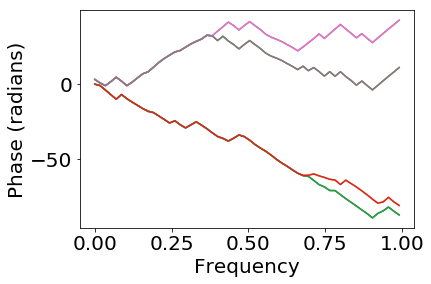

In [26]:
spec, freq, _ = plt.phase_spectrum(half_trace_left, label="Phase")
hann_spec, hann_freq, _ = plt.phase_spectrum(hann_half_trace_left, label="Phase Hanning")

spec_total = spec
hann_spec_total = hann_spec
frex_total = freq
hann_frex_total = hann_freq

spec, freq, _ = plt.phase_spectrum(half_trace_midl)
hann_spec, hann_freq, _ = plt.phase_spectrum(hann_half_trace_midl)

spec_total += spec
hann_spec_total += hann_spec

spec, freq, _ = plt.phase_spectrum(half_trace_midr)
hann_spec, hann_freq, _ = plt.phase_spectrum(hann_half_trace_midr)

spec_total += spec
hann_spec_total += hann_spec

spec, freq, _ = plt.phase_spectrum(half_trace_right)
hann_spec, hann_freq, _ = plt.phase_spectrum(hann_half_trace_right)

spec_total += spec
hann_spec_total += hann_spec



C:\Users\jdram\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


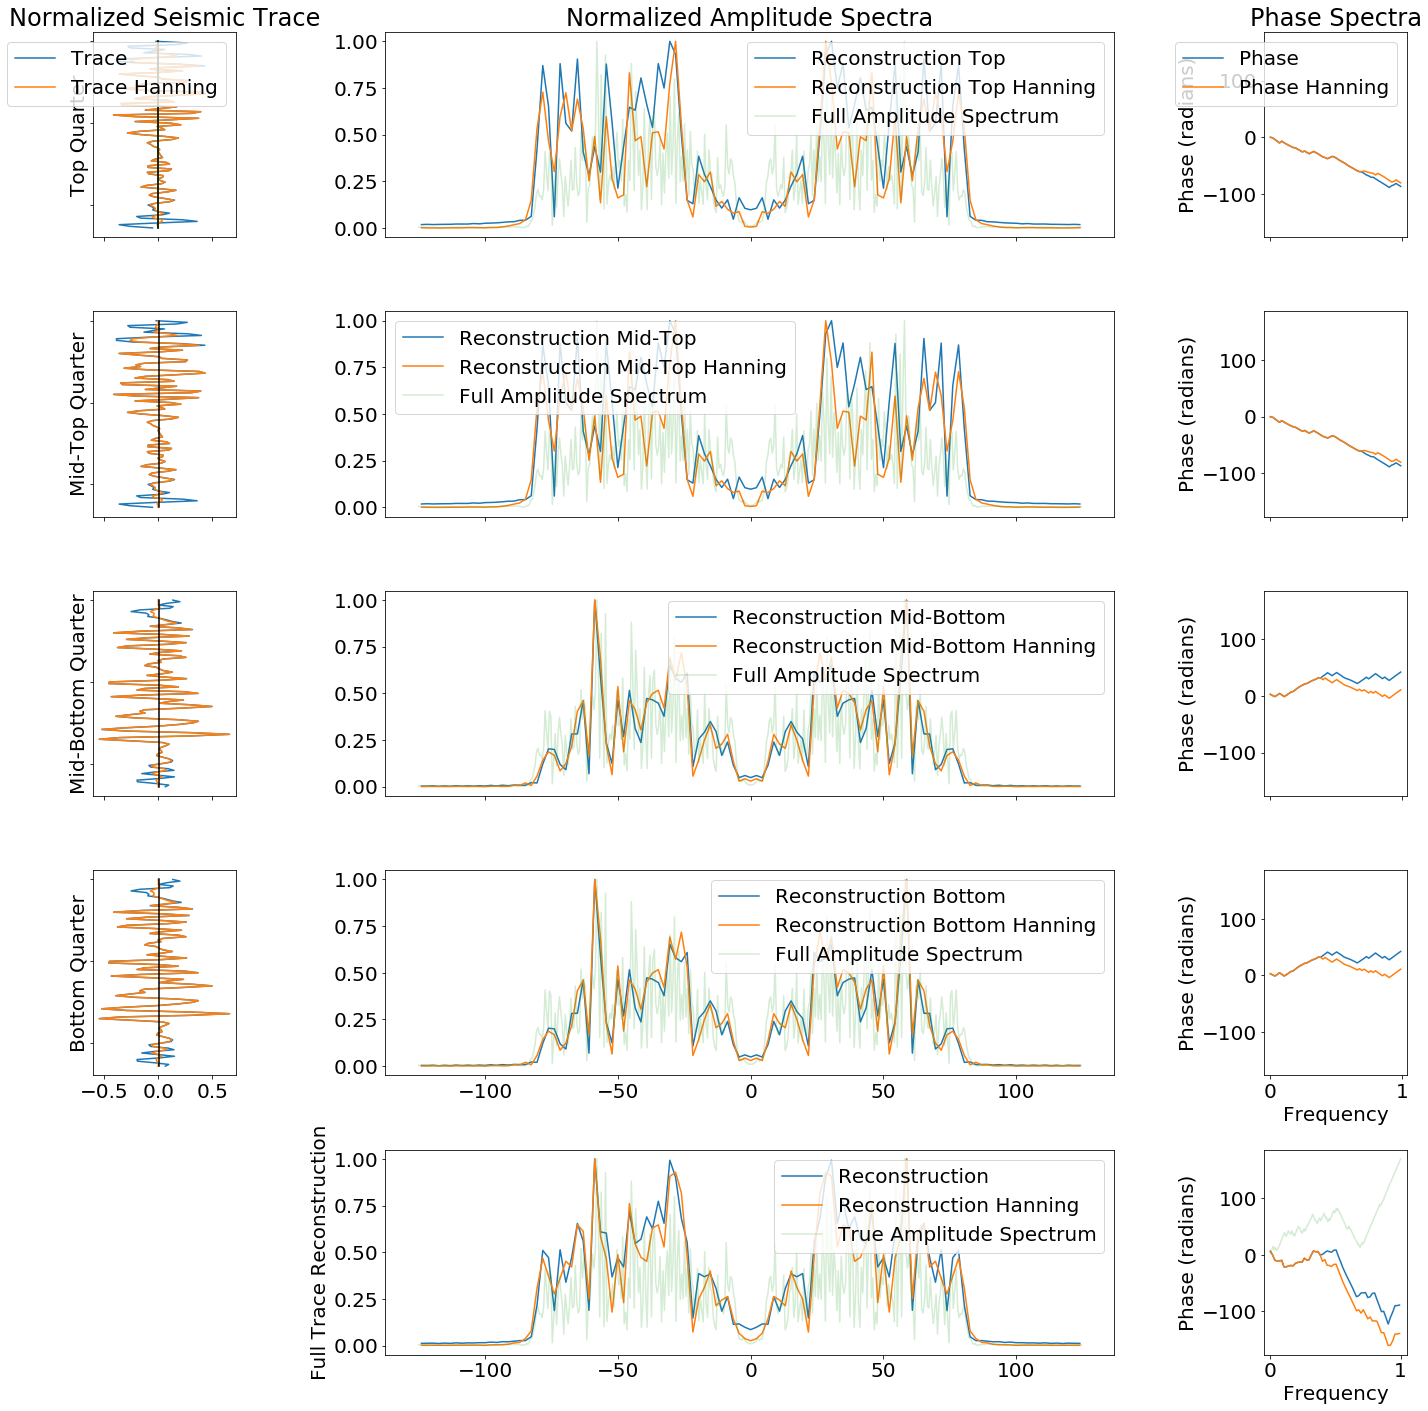

In [27]:
plt.figure(figsize=(20, 20), tight_layout=True)

ax12 = plt.subplot2grid((5, 5), (0, 1), colspan=3)
ax12.plot(freqs_left[idx_left], (sp_left[idx_left]), label="Reconstruction Top")
ax12.plot(hann_freqs_left[hann_idx_left], (hann_sp_left[hann_idx_left]), label="Reconstruction Top Hanning")
ax12.plot(freqs[idx], sp[idx], label="Full Amplitude Spectrum", alpha=.2)
ax12.set_title("Normalized Amplitude Spectra")
ax12.legend()
plt.setp(ax12.get_xticklabels(), visible=False)
ax13 = plt.subplot2grid((5, 5), (1, 1), colspan=3)
ax13.plot(freqs_midl[idx_midl], (sp_midl[idx_midl]), label="Reconstruction Mid-Top")
ax13.plot(hann_freqs_midl[hann_idx_midl], (hann_sp_midl[hann_idx_midl]), label="Reconstruction Mid-Top Hanning")
ax13.plot(freqs[idx], sp[idx], label="Full Amplitude Spectrum", alpha=.2)
ax13.legend()
plt.setp(ax13.get_xticklabels(), visible=False)
ax14 = plt.subplot2grid((5, 5), (2, 1), colspan=3)
ax14.plot(freqs_midr[idx_midr], (sp_midr[idx_midr]), label="Reconstruction Mid-Bottom")
ax14.plot(hann_freqs_midr[hann_idx_midr], (hann_sp_midr[hann_idx_midr]), label="Reconstruction Mid-Bottom Hanning")
ax14.plot(freqs[idx], sp[idx], label="Full Amplitude Spectrum", alpha=.2)
ax14.legend()
plt.setp(ax14.get_xticklabels(), visible=False)
ax15 = plt.subplot2grid((5, 5), (3, 1), colspan=3)
ax15.plot(freqs_right[idx_right], (sp_right[idx_right]), label="Reconstruction Bottom")
ax15.plot(hann_freqs_right[hann_idx_right], (hann_sp_right[hann_idx_right]), label="Reconstruction Bottom Hanning")
ax15.plot(freqs[idx], sp[idx], label="Full Amplitude Spectrum", alpha=.2)
ax15.legend()


ax1 = plt.subplot2grid((5, 5), (0, 0))
ax1.plot(half_trace_left,-np.arange(len(half_trace_left)), label="Trace")
ax1.plot(hann_half_trace_left,-np.arange(len(hann_half_trace_left)), label="Trace Hanning")
ax1.plot(np.repeat(0,len(half_trace_left)),-np.arange(len(half_trace_left)))
ax1.plot(np.repeat(np.mean(half_trace_left),len(half_trace_left)),-np.arange(len(half_trace_left)), 'k')
ax1.set_title("Normalized Seismic Trace")
ax1.set_ylabel("Top Quarter")
ax1.legend()
ax2 = plt.subplot2grid((5, 5), (1, 0), sharex=ax1)
ax2.plot(half_trace_midl,-np.arange(len(half_trace_midl)))
ax2.plot(hann_half_trace_midl,-np.arange(len(hann_half_trace_midl)))
ax2.plot(np.repeat(np.mean(half_trace_midr),len(half_trace_midr)),-np.arange(len(half_trace_midr)), 'k')
ax2.set_ylabel("Mid-Top Quarter")
plt.setp(ax1.get_yticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot2grid((5, 5), (2, 0), sharex=ax1)
ax3.plot(half_trace_midr,-np.arange(len(half_trace_midl)))
ax3.plot(hann_half_trace_midr,-np.arange(len(hann_half_trace_midl)))
ax3.plot(np.repeat(np.mean(half_trace_midr),len(half_trace_midr)),-np.arange(len(half_trace_midr)), 'k')
ax3.set_ylabel("Mid-Bottom Quarter")
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)

ax4 = plt.subplot2grid((5, 5), (3, 0), sharex=ax1)
ax4.plot(half_trace_right,-np.arange(len(half_trace_right)))
ax4.plot(hann_half_trace_right,-np.arange(len(hann_half_trace_right)))
ax4.plot(np.repeat(np.mean(half_trace_right),len(half_trace_right)),-np.arange(len(half_trace_right)), 'k')
ax4.set_ylabel("Bottom Quarter")
plt.setp(ax4.get_yticklabels(), visible=False)

ax61 = plt.subplot2grid((5, 5), (0, 4))
ax61.set_title("Phase Spectra")
ax61.phase_spectrum(half_trace_left, label="Phase")
ax61.phase_spectrum(hann_half_trace_left, label="Phase Hanning")
ax61.legend()
ax61.set_xlabel("")
plt.setp(ax61.get_xticklabels(), visible=False)
ax62 = plt.subplot2grid((5, 5), (1, 4), sharey=ax61)
ax62.phase_spectrum(half_trace_midl)
ax62.phase_spectrum(hann_half_trace_midl)
ax62.set_xlabel("")
plt.setp(ax62.get_xticklabels(), visible=False)
ax63 = plt.subplot2grid((5, 5), (2, 4), sharey=ax61)
ax63.phase_spectrum(half_trace_midr)
ax63.phase_spectrum(hann_half_trace_midr)
ax63.set_xlabel("")
plt.setp(ax63.get_xticklabels(), visible=False)
ax64 = plt.subplot2grid((5, 5), (3, 4), sharey=ax61)
ax64.phase_spectrum(half_trace_right)
ax64.phase_spectrum(hann_half_trace_right)

sp_rec = sp_left_true[idx_left]+sp_midl_true[idx_midl]+sp_midr_true[idx_midr]+sp_right_true[idx_right]
sp_rec /= np.max(sp_rec)
hann_sp_rec = hann_sp_left_true[hann_idx_left]+hann_sp_midl_true[hann_idx_midl]+hann_sp_midr_true[hann_idx_midr]+hann_sp_right_true[hann_idx_right]
hann_sp_rec /= np.max(hann_sp_rec)

ax71 = plt.subplot2grid((5, 5), (4, 1), colspan=3)
plt.plot(freqs_left[idx_left], sp_rec, label="Reconstruction")
ax71.plot(hann_freqs_right[hann_idx_right], hann_sp_rec, label="Reconstruction Hanning")
ax71.plot(freqs[idx], sp[idx], label="True Amplitude Spectrum", alpha=.2)
ax71.set_ylabel("Full Trace Reconstruction")
ax71.legend()

ax74 = plt.subplot2grid((5, 5), (4, 4), sharey=ax61)
ax74.plot(frex_total,spec_total, label="Reconstruction")
ax74.plot(hann_frex_total,hann_spec_total, label="Reconstruction Hanning")
ax74.phase_spectrum(trace, label="True Phase Spectrum", alpha=.2)


plt.savefig("spectral.png")

plt.show()